In [ ]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/rosenfeldb/112-Final-Project/refs/heads/main/member_conformity_with_full_metadata.csv")

In [ ]:
import re

# Remove anything in parentheses from member_name and strip whitespace
df["member_name"] = df["member_name"].str.replace(r"\s*\(.*?\)", "", regex=True).str.strip()

# Optional: Standardize capitalization
df["member_name"] = df["member_name"].str.title()  # or .str.upper() if you prefer

In [ ]:
# Step 1: Create a key combining name and state
df["person_key"] = df["member_name"].str.upper().str.strip() + "|" + df["state"]

# Step 2: Extract known bio data
bio_fields = ["birth_year", "first_year_served", "gender"]
known_bio = (
    df.dropna(subset=bio_fields)
      .drop_duplicates(subset=["person_key"])
      .set_index("person_key")[bio_fields]
)

# Step 3: Map known values back into full dataframe
for col in bio_fields:
    df[col] = df[col].fillna(df["person_key"].map(known_bio[col]))

# Step 4: Drop the helper column
df.drop(columns="person_key", inplace=True)

In [ ]:
import re

# Step 1: Redo chamber based on member_id format
def infer_chamber(member_id):
    if re.fullmatch(r"[A-Z]\d{3}", member_id):  # e.g. S247
        return "sen"
    elif re.fullmatch(r"[A-Z]\d{6}", member_id):  # e.g. S000148
        return "rep"
    else:
        return None  # fallback

df["chamber"] = df["member_id"].apply(infer_chamber)

In [ ]:
df["year"] = 1789 + 2 * (df["congress"] - 1)

In [ ]:
cur = pd.read_csv("https://raw.githubusercontent.com/rosenfeldb/112-Final-Project/refs/heads/main/legislators-current%20(3).csv")
hist = pd.read_csv("https://raw.githubusercontent.com/rosenfeldb/112-Final-Project/refs/heads/main/legislators-historical.csv")

In [ ]:
legislators = pd.concat([cur, hist], ignore_index=True)

# Filter to House members with district info
house_with_district = legislators[
    (legislators["type"] == "rep") & (legislators["district"].notna())
].copy()

# Create match key from last name and state
house_with_district["match_key"] = (
    house_with_district["last_name"].str.upper().str.strip() + "|" + house_with_district["state"]
)

# Create mapping from match_key → district
district_map = house_with_district.set_index("match_key")["district"].to_dict()

# Apply same match_key in main df
df["match_key"] = df["member_name"].str.upper().str.strip() + "|" + df["state"]

# Replace district values for all House members
mask = df["chamber"] == "rep"
df.loc[mask, "district"] = df.loc[mask, "match_key"].map(district_map)

# Clean up
df.drop(columns="match_key", inplace=True)

In [ ]:
df[df["state"]=="WA"]

,member_id,member_name,party,state,congress,avg_simple_conformity,avg_entropy_conformity,votes_cast,birth_year,first_year_served,gender,chamber,district,year
615,B001229,Baird,D,WA,106,0.882155,0.601831,1188,1956.0,1999.0,M,rep,3.0,1999
616,B001229,Baird,D,WA,107,0.875386,0.635987,971,1956.0,1999.0,M,rep,3.0,2001
617,B001229,Baird,D,WA,108,0.919011,0.725885,1173,1956.0,1999.0,M,rep,3.0,2003
618,B001229,Baird,D,WA,109,0.909238,0.691699,617,1956.0,1999.0,M,rep,3.0,2005
619,B001229,Baird,D,WA,110,0.952408,0.834504,1765,1956.0,1999.0,M,rep,3.0,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,U000017,Unsoeld,D,WA,101,0.942623,0.623000,488,1931.0,1989.0,F,rep,3.0,1989
9797,U000017,Unsoeld,D,WA,102,0.923429,0.581069,875,1931.0,1989.0,F,rep,3.0,1991
9798,U000017,Unsoeld,D,WA,103,0.913907,0.583794,1057,1931.0,1989.0,F,rep,3.0,1993
10047,W000391,White,R,WA,104,0.915319,0.677440,1299,1953.0,1995.0,M,rep,1.0,1995


In [ ]:
df.to_csv("conform.csv", index=False)

In [ ]:
senate_elections = pd.read_csv("https://raw.githubusercontent.com/rosenfeldb/112-Final-Project/refs/heads/main/1976-2020-senate.csv")
senate_elections["percentage_vote"] = senate_elections["candidatevotes"]/senate_elections["totalvotes"]
house_elections =  pd.read_csv("https://raw.githubusercontent.com/rosenfeldb/112-Final-Project/refs/heads/main/1976-2022-house.csv")
house_elections["percentage_vote"] = house_elections["candidatevotes"]/house_elections["totalvotes"]
house_elections

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,...,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version,fusion_ticket,percentage_vote
0,1976,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,...,BILL DAVENPORT,DEMOCRAT,False,TOTAL,58906,157170,False,20230706,False,0.374792
1,1976,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,...,JACK EDWARDS,REPUBLICAN,False,TOTAL,98257,157170,False,20230706,False,0.625164
2,1976,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,...,WRITEIN,NaN,True,TOTAL,7,157170,False,20230706,False,0.000045
3,1976,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,False,...,J CAROLE KEAHEY,DEMOCRAT,False,TOTAL,66288,156362,False,20230706,False,0.423939
4,1976,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,False,...,"WILLIAM L ""BILL"" DICKINSON",REPUBLICAN,False,TOTAL,90069,156362,False,20230706,False,0.576029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32447,2022,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,RICHARD BRUBAKER,LIBERTARIAN,False,TOTAL,5420,198198,False,20230706,False,0.027346
32448,2022,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,MARISSA JOY SELVIG,CONSTITUTION,False,TOTAL,4505,198198,False,20230706,False,0.022730
32449,2022,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,WRITEIN,NaN,True,TOTAL,4521,198198,False,20230706,False,0.022811
32450,2022,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,UNDERVOTES,NaN,False,TOTAL,3660,198198,False,20230706,False,0.018466


In [ ]:
import pandas as pd


# 1. Filter general election, total mode, not write-ins
def clean_elections(df, is_house=True):
    df = df[
        (df["stage"] == "GEN") &
        (df["mode"] == "TOTAL") &
        (~df["writein"])
    ].copy()
    df["last_name"] = df["candidate"].str.upper().str.strip().str.split().str[-1]
    df["term_start_year"] = df["year"] + 1
    if is_house:
        df["district_str"] = df["district"].astype(str)
        df["match_key"] = (
            df["last_name"] + "|" +
            df["state_po"] + "|" +
            df["district_str"] + "|" +
            df["term_start_year"].astype(str)
        )
    else:
        df["match_key"] = (
            df["last_name"] + "|" +
            df["state_po"] + "|" +
            df["term_start_year"].astype(str)
        )
    return (
        df.sort_values("percentage_vote", ascending=False)
          .drop_duplicates("match_key")[["match_key", "percentage_vote"]]
    )

house_winners = clean_elections(house_elections, is_house=True)
senate_winners = clean_elections(senate_elections, is_house=False)

df["last_name"] = df["member_name"].str.upper().str.strip().str.split().str[-1]
df["district_str"] = df["district"].fillna("NA").astype(str)
df["term_start_year"] = df["year"]

df["match_key"] = df.apply(
    lambda row: (
        f"{row['last_name']}|{row['state']}|{row['district_str']}|{row['term_start_year']}"
        if row["chamber"] == "rep" else
        f"{row['last_name']}|{row['state']}|{row['term_start_year']}"
    ), axis=1
)

# 3. Merge
winners = pd.concat([house_winners, senate_winners], ignore_index=True)
df = df.merge(winners, on="match_key", how="left")
df.rename(columns={"percentage_vote": "vote_pct"}, inplace=True)

# 4. Clean up
df.drop(columns=["last_name", "district_str", "term_start_year", "match_key"], inplace=True)

# Save if needed
df.to_csv("conform_with_vote_pct.csv", index=False)

In [ ]:
df[df["state"]=="OR"]

,member_id,member_name,party,state,congress,avg_simple_conformity,avg_entropy_conformity,votes_cast,birth_year,first_year_served,gender,chamber,district,year,vote_pct
90,A000337,Aucoin,D,OR,101,0.917778,0.609230,450,1942.0,1975.0,M,rep,1.0,1989,NaN
91,A000337,Aucoin,D,OR,102,0.918775,0.564765,751,1942.0,1975.0,M,rep,1.0,1991,NaN
380,B000574,Blumenauer,D,OR,104,0.918033,0.471022,244,1948.0,1996.0,M,rep,3.0,1995,NaN
381,B000574,Blumenauer,D,OR,105,0.902765,0.546624,1121,1948.0,1996.0,M,rep,3.0,1997,NaN
382,B000574,Blumenauer,D,OR,106,0.909013,0.609304,1165,1948.0,1996.0,M,rep,3.0,1999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10155,W000793,Wu,D,OR,108,0.926325,0.727276,1208,1955.0,1999.0,M,rep,1.0,2003,NaN
10156,W000793,Wu,D,OR,109,0.911278,0.697346,665,1955.0,1999.0,M,rep,1.0,2005,NaN
10157,W000793,Wu,D,OR,110,0.969499,0.845798,1836,1955.0,1999.0,M,rep,1.0,2007,NaN
10158,W000793,Wu,D,OR,111,0.967803,0.821627,1584,1955.0,1999.0,M,rep,1.0,2009,NaN


In [ ]:
df

,member_id,member_name,party,state,congress,avg_simple_conformity,avg_entropy_conformity,votes_cast,birth_year,first_year_served,gender,chamber,district,year,vote_pct
0,A000014,Abercrombie,D,HI,102,0.918391,0.571641,870,1938.0,1985.0,M,rep,1.0,1991,NaN
1,A000014,Abercrombie,D,HI,103,0.887392,0.557250,1039,1938.0,1985.0,M,rep,1.0,1993,NaN
2,A000014,Abercrombie,D,HI,104,0.850196,0.453973,1275,1938.0,1985.0,M,rep,1.0,1995,NaN
3,A000014,Abercrombie,D,HI,105,0.875436,0.540138,1148,1938.0,1985.0,M,rep,1.0,1997,NaN
4,A000014,Abercrombie,D,HI,106,0.912968,0.601611,1149,1938.0,1985.0,M,rep,1.0,1999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10398,Z000017,Zeldin,R,NY,117,0.957763,0.710056,876,1980.0,2015.0,M,rep,1.0,2021,NaN
10399,Z000018,Zinke,R,MT,114,0.944790,0.767999,1286,1961.0,2015.0,M,rep,1.0,2015,NaN
10400,Z000018,Zinke,R,MT,115,1.000000,0.947145,18,1961.0,2015.0,M,rep,1.0,2017,NaN
10401,Z000018,Zinke,R,MT,118,0.924544,0.699453,1206,1961.0,2015.0,M,rep,1.0,2023,NaN


<ipython-input-18-aadb244cc0cd>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  senators.groupby(["term_stage", "tenure_group"])["avg_entropy_conformity"]


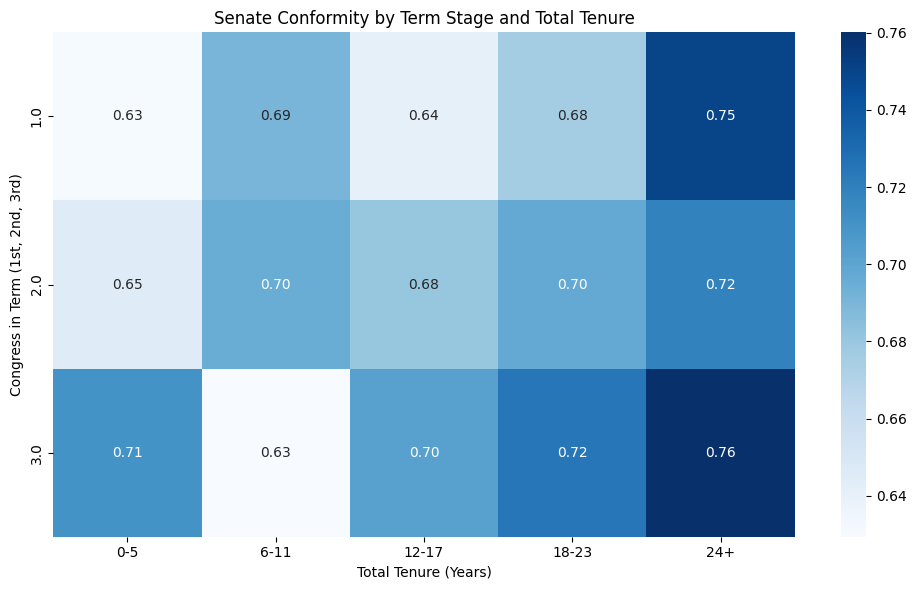

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to senators
senators = df[df["chamber"] == "sen"].copy()

# Compute how far into Senate term
senators["years_into_term"] = senators["year"] - senators["first_year_served"]
senators["term_stage"] = (senators["years_into_term"] // 2) % 3 + 1  # values 1, 2, 3

# Compute total tenure at time of vote
senators["senate_tenure"] = senators["year"] - senators["first_year_served"]

# Bin tenure into ranges (you can customize bins as needed)
bins = [0, 6, 12, 18, 24, 50]
labels = ["0-5", "6-11", "12-17", "18-23", "24+"]
senators["tenure_group"] = pd.cut(senators["senate_tenure"], bins=bins, labels=labels, right=False)

# Group by both term stage and tenure group
grouped = (
    senators.groupby(["term_stage", "tenure_group"])["avg_entropy_conformity"]
    .mean()
    .unstack()
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(grouped, annot=True, cmap="Blues", fmt=".2f")
plt.title("Senate Conformity by Term Stage and Total Tenure")
plt.xlabel("Total Tenure (Years)")
plt.ylabel("Congress in Term (1st, 2nd, 3rd)")
plt.tight_layout()
plt.show()


<ipython-input-20-29c4acf1658e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_members["is_outlier"] = (current_members["conformity"] < lower) | (current_members["conformity"] > upper)
<ipython-input-20-29c4acf1658e>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_members["color"] = current_members["party"].map(party_color)


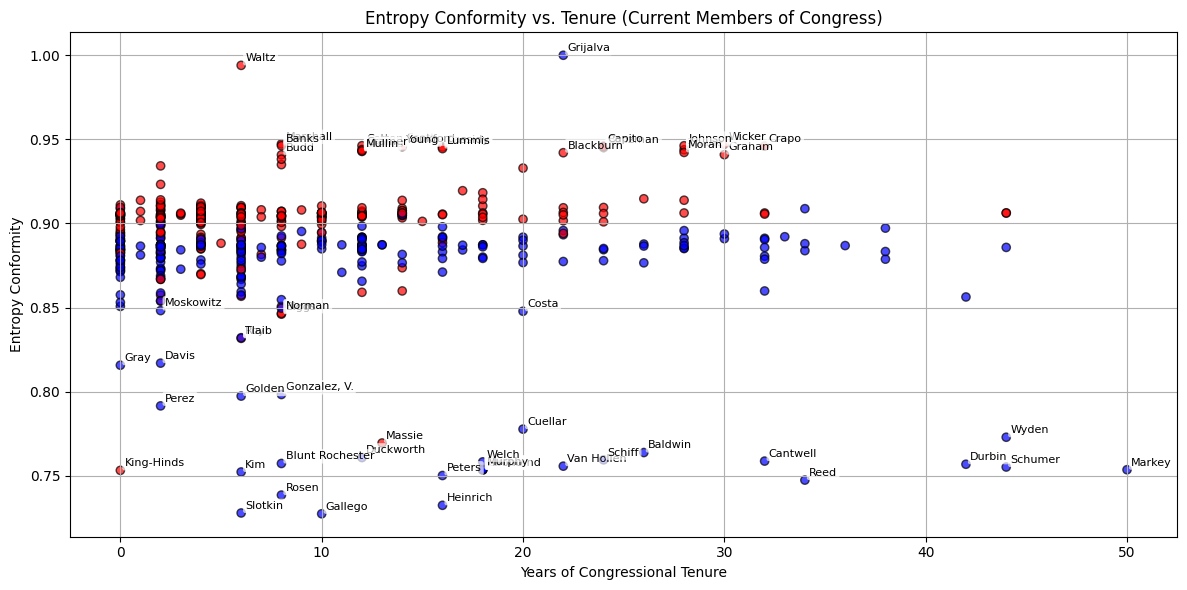

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for most recent Congress
latest_congress = df["congress"].max()
current_members = df[df["congress"] == latest_congress].copy()

# Use entropy conformity
current_members["conformity"] = current_members["avg_entropy_conformity"]

# Compute tenure
current_members["tenure"] = current_members["year"] - current_members["first_year_served"]

# Drop rows without tenure
current_members = current_members.dropna(subset=["tenure", "conformity"])

# Identify outliers (1.5 IQR rule)
q1 = current_members["conformity"].quantile(0.25)
q3 = current_members["conformity"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
current_members["is_outlier"] = (current_members["conformity"] < lower) | (current_members["conformity"] > upper)

# Set party colors
party_color = {"D": "blue", "R": "red"}
current_members["color"] = current_members["party"].map(party_color)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(
    current_members["tenure"],
    current_members["conformity"],
    c=current_members["color"],
    edgecolor="black",
    alpha=0.7
)

# Label outliers
for _, row in current_members[current_members["is_outlier"]].iterrows():
    plt.annotate(
        row["member_name"],
        xy=(row["tenure"], row["conformity"]),
        xytext=(3, 3),  # offset
        textcoords="offset points",
        fontsize=8,
        ha="left",
        color="black",
        bbox=dict(boxstyle="round,pad=0.2", edgecolor="none", facecolor="white", alpha=0.7)
    )


plt.title("Entropy Conformity vs. Tenure (Current Members of Congress)")
plt.xlabel("Years of Congressional Tenure")
plt.ylabel("Entropy Conformity")
plt.grid(True)
plt.tight_layout()
plt.show()


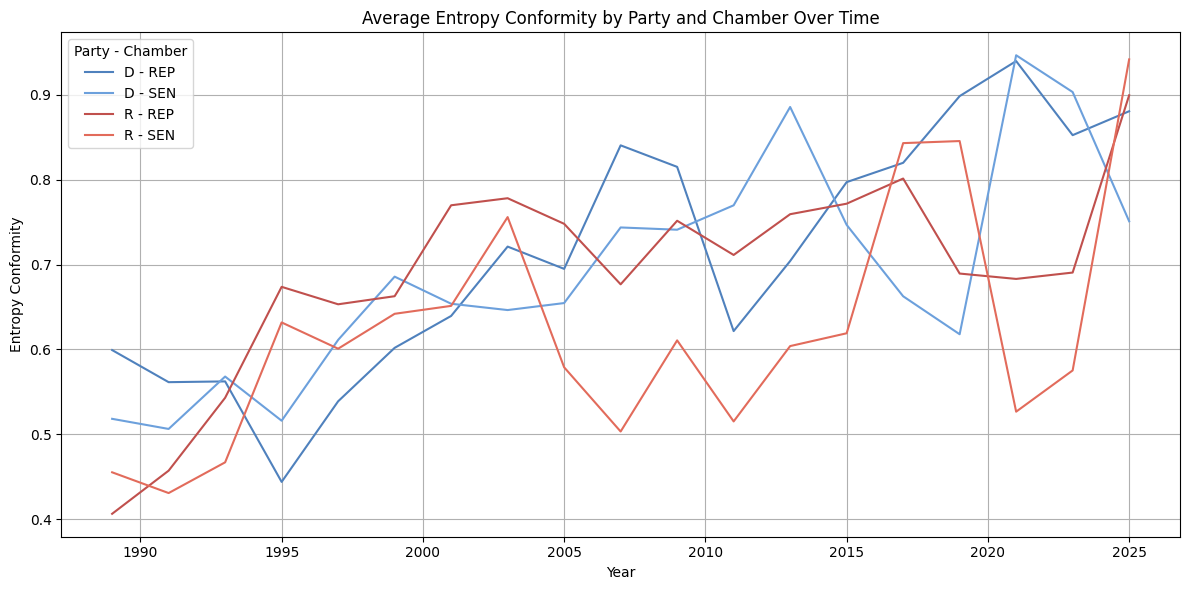

In [ ]:
party_chamber_conformity = (
    df.groupby(["year", "party", "chamber"])["avg_entropy_conformity"]
    .mean()
    .reset_index()
)

# Define custom colors
party_chamber_colors = {
    ("D", "rep"): "#4F81BD",  # Blueish for House Democrats
    ("D", "sen"): "#6CA0DC",  # Lighter blue for Senate Democrats
    ("R", "rep"): "#C0504D",  # Redish for House Republicans
    ("R", "sen"): "#E26B5B",  # Lighter red for Senate Republicans
}

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot each group with color
for (party, chamber), group in party_chamber_conformity.groupby(["party", "chamber"]):
    label = f"{party} - {chamber.upper()}"
    color = party_chamber_colors.get((party, chamber), "gray")  # Default to gray
    plt.plot(group["year"], group["avg_entropy_conformity"], label=label, color=color)

# Customize plot
plt.title("Average Entropy Conformity by Party and Chamber Over Time")
plt.xlabel("Year")
plt.ylabel("Entropy Conformity")
plt.legend(title="Party - Chamber")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Filter only Dem/Rep members
votes_only = df[df["party"].isin(["D", "R"])].copy()

# Count members by party, congress, and chamber
counts = (
    votes_only.groupby(["congress", "chamber", "party"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Compute margin: Dems - Reps
counts["margin_of_control"] = counts["D"] - counts["R"]

# Merge back into original df
df = df.merge(
    counts[["congress", "chamber", "margin_of_control"]],
    on=["congress", "chamber"],
    how="left"
)

In [ ]:
df.drop(columns=["margin_of_control_x", "margin_of_control_y"], inplace=True)
df

,member_id,member_name,party,state,congress,avg_simple_conformity,avg_entropy_conformity,votes_cast,birth_year,first_year_served,gender,chamber,district,year,vote_pct,margin_of_control
0,A000014,Abercrombie,D,HI,102,0.918391,0.571641,870,1938.0,1985.0,M,rep,1.0,1991,NaN,99
1,A000014,Abercrombie,D,HI,103,0.887392,0.557250,1039,1938.0,1985.0,M,rep,1.0,1993,NaN,84
2,A000014,Abercrombie,D,HI,104,0.850196,0.453973,1275,1938.0,1985.0,M,rep,1.0,1995,NaN,-27
3,A000014,Abercrombie,D,HI,105,0.875436,0.540138,1148,1938.0,1985.0,M,rep,1.0,1997,NaN,-19
4,A000014,Abercrombie,D,HI,106,0.912968,0.601611,1149,1938.0,1985.0,M,rep,1.0,1999,NaN,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10398,Z000017,Zeldin,R,NY,117,0.957763,0.710056,876,1980.0,2015.0,M,rep,1.0,2021,NaN,12
10399,Z000018,Zinke,R,MT,114,0.944790,0.767999,1286,1961.0,2015.0,M,rep,1.0,2015,NaN,-60
10400,Z000018,Zinke,R,MT,115,1.000000,0.947145,18,1961.0,2015.0,M,rep,1.0,2017,NaN,-50
10401,Z000018,Zinke,R,MT,118,0.924544,0.699453,1206,1961.0,2015.0,M,rep,1.0,2023,NaN,-8


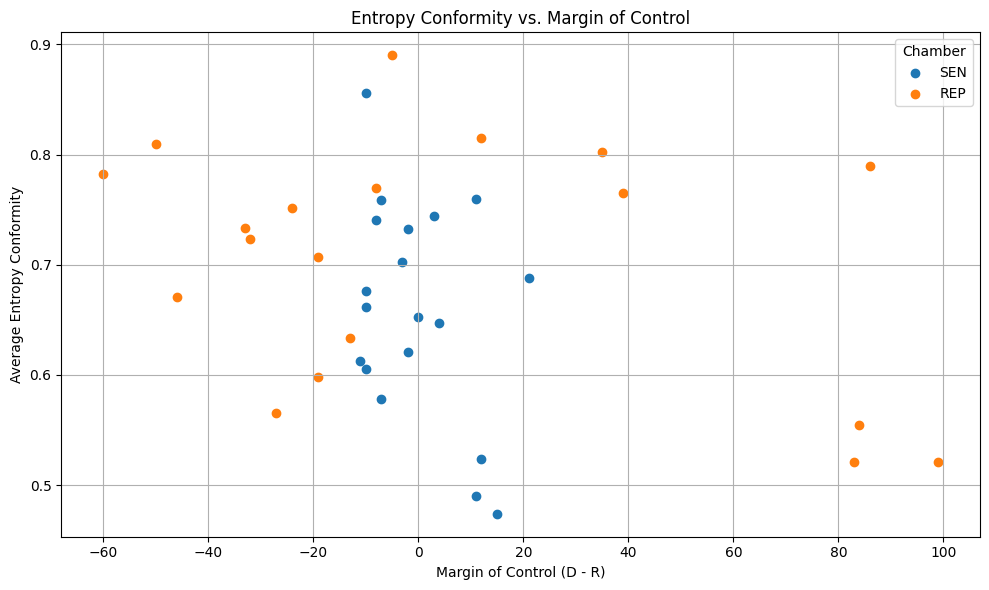

In [ ]:
import matplotlib.pyplot as plt

# Group by congress and chamber, take mean conformity and margin
summary = (
    df.groupby(["congress", "chamber"])[["avg_entropy_conformity", "margin_of_control"]]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 6))
for chamber in ["sen", "rep"]:
    data = summary[summary["chamber"] == chamber]
    plt.scatter(
        data["margin_of_control"],
        data["avg_entropy_conformity"],
        label=chamber.upper()
    )

plt.title("Entropy Conformity vs. Margin of Control")
plt.xlabel("Margin of Control (D - R)")
plt.ylabel("Average Entropy Conformity")
plt.legend(title="Chamber")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-33-a06856e35b9a>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "margin_bucket"])["avg_entropy_conformity"]


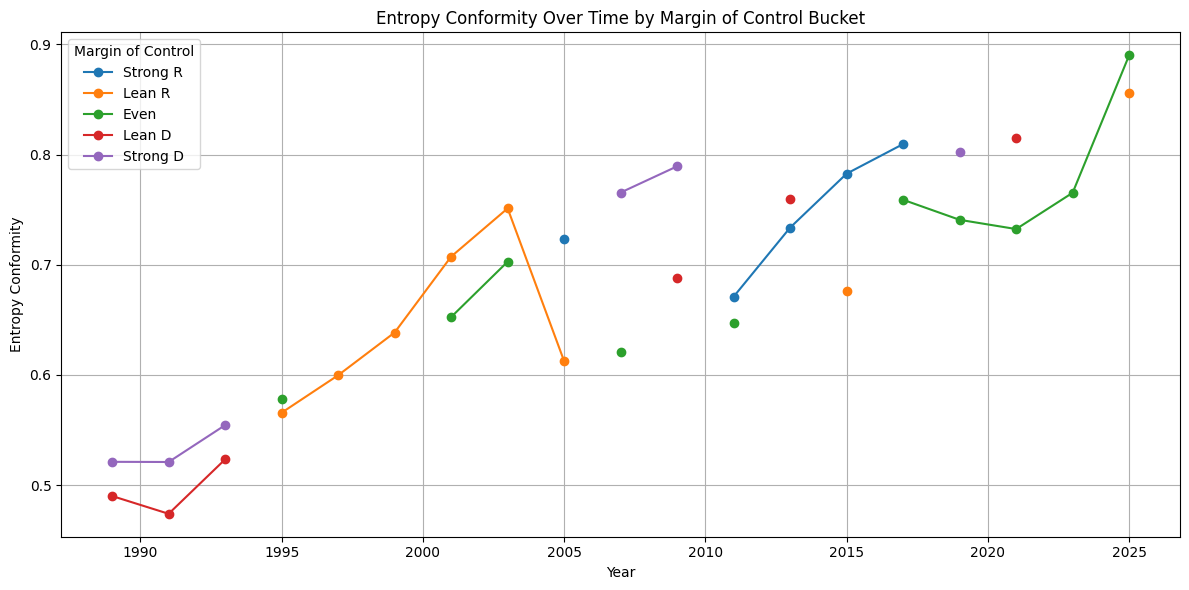

In [ ]:
# Step 1: Filter for Dem/Rep only
votes_only = df[df["party"].isin(["D", "R"])].copy()

# Step 2: Compute party counts per congress and chamber
counts = (
    votes_only.groupby(["congress", "chamber", "party"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 3: Compute margin (D - R)
counts["margin_of_control"] = counts["D"] - counts["R"]

# Step 4: Merge back into full df
df = df.merge(
    counts[["congress", "chamber", "margin_of_control"]],
    on=["congress", "chamber"],
    how="left"
)

# Step 5: Create margin buckets
df["margin_bucket"] = pd.cut(
    df["margin_of_control"],
    bins=[-999, -30, -10, 10, 30, 999],
    labels=["Strong R", "Lean R", "Even", "Lean D", "Strong D"]
)

# Step 6: Group and plot
bucket_summary = (
    df.groupby(["year", "margin_bucket"])["avg_entropy_conformity"]
    .mean()
    .reset_index()
)

bucket_pivot = bucket_summary.pivot(index="year", columns="margin_bucket", values="avg_entropy_conformity")

# Plot
plt.figure(figsize=(12, 6))
bucket_pivot.plot(ax=plt.gca(), marker="o")
plt.title("Entropy Conformity Over Time by Margin of Control Bucket")
plt.xlabel("Year")
plt.ylabel("Entropy Conformity")
plt.grid(True)
plt.legend(title="Margin of Control")
plt.tight_layout()
plt.show()


<ipython-input-34-762fecefbe25>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


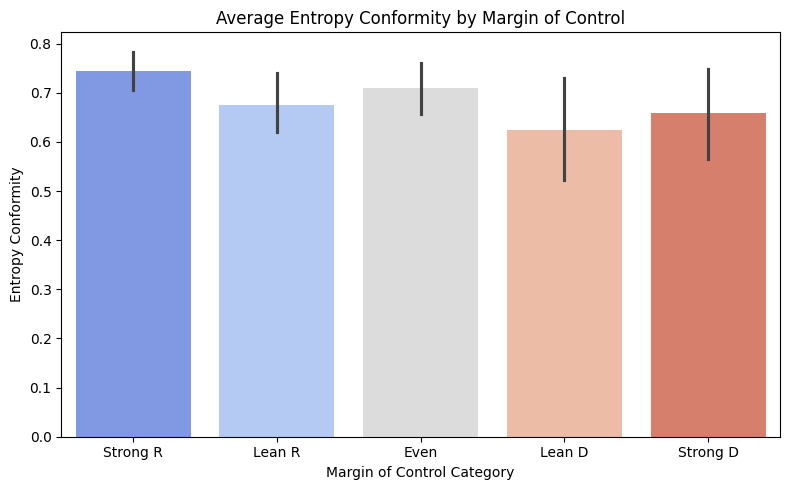

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=bucket_summary,
    x="margin_bucket",
    y="avg_entropy_conformity",
    palette="coolwarm"
)
plt.title("Average Entropy Conformity by Margin of Control")
plt.xlabel("Margin of Control Category")
plt.ylabel("Entropy Conformity")
plt.tight_layout()
plt.show()

<ipython-input-35-f3e6208a23ae>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["margin_bucket", "party"])["avg_entropy_conformity"]


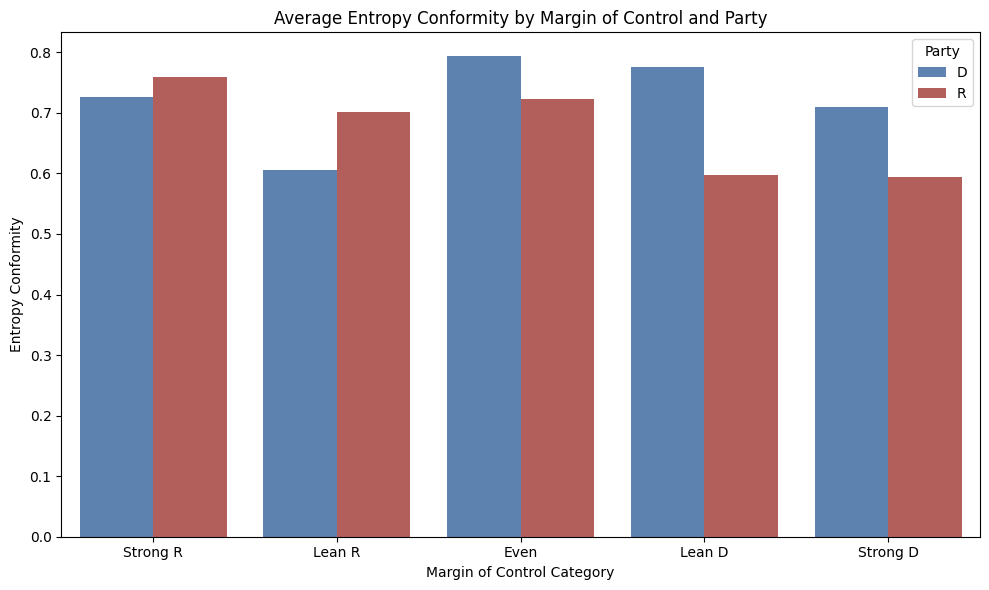

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load main data
df = pd.read_csv("conform.csv")

# Compute party counts per congress and chamber
party_counts = (
    df[df["party"].isin(["D", "R"])]
    .groupby(["congress", "chamber", "party"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Compute margin: Dems - Republicans
party_counts["margin_of_control"] = party_counts["D"] - party_counts["R"]

# Merge margin back into df
df = df.merge(
    party_counts[["congress", "chamber", "margin_of_control"]],
    on=["congress", "chamber"],
    how="left"
)

# Bucket the margin values
df["margin_bucket"] = pd.cut(
    df["margin_of_control"],
    bins=[-999, -30, -10, 10, 30, 999],
    labels=["Strong R", "Lean R", "Even", "Lean D", "Strong D"]
)

# Group by margin bucket and party, compute average entropy conformity
bucket_party_summary = (
    df[df["party"].isin(["D", "R"])]
    .groupby(["margin_bucket", "party"])["avg_entropy_conformity"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bucket_party_summary,
    x="margin_bucket",
    y="avg_entropy_conformity",
    hue="party",
    palette={"D": "#4F81BD", "R": "#C0504D"}
)

plt.title("Average Entropy Conformity by Margin of Control and Party")
plt.xlabel("Margin of Control Category")
plt.ylabel("Entropy Conformity")
plt.legend(title="Party")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Group by state to compute average entropy conformity
state_conformity = (
    df.groupby("state")["avg_entropy_conformity"]
    .mean()
    .reset_index()
)


# Choose a perceptually uniform, high-contrast colormap
fig = px.choropleth(
    state_conformity,
    locations="state",
    locationmode="USA-states",
    color="avg_entropy_conformity",
    scope="usa",
    color_continuous_scale="Plasma",  # perceptually uniform & high contrast
    range_color=[0.5, 0.8],  # stretch contrast between reasonable limits
    labels={"avg_entropy_conformity": "Entropy Conformity"},
    hover_data={"avg_entropy_conformity": ":.3f"},
    title="Average Entropy Conformity by State<br><sup>Higher = More consistent with party</sup>"
)

fig.update_layout(
    geo=dict(lakecolor="white"),
    margin={"r":0,"t":60,"l":0,"b":0}
)

fig.show()



<ipython-input-40-b95696765042>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




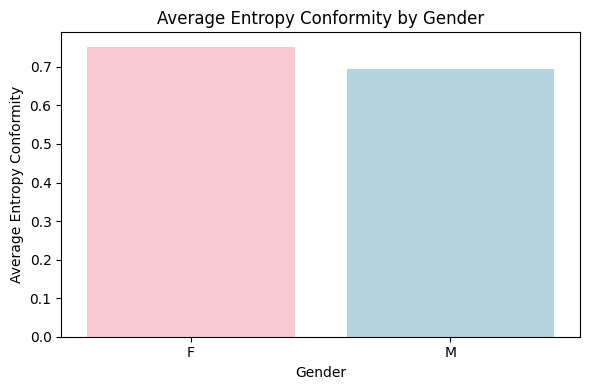

In [ ]:
# Drop rows with missing gender
gender_df = df[df["gender"].isin(["M", "F"])].copy()

# Group by gender and calculate average entropy conformity
gender_conformity = (
    gender_df.groupby("gender")["avg_entropy_conformity"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=gender_conformity, x="gender", y="avg_entropy_conformity", palette={"M": "lightblue", "F": "pink"})
plt.title("Average Entropy Conformity by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Entropy Conformity")
plt.tight_layout()
plt.show()

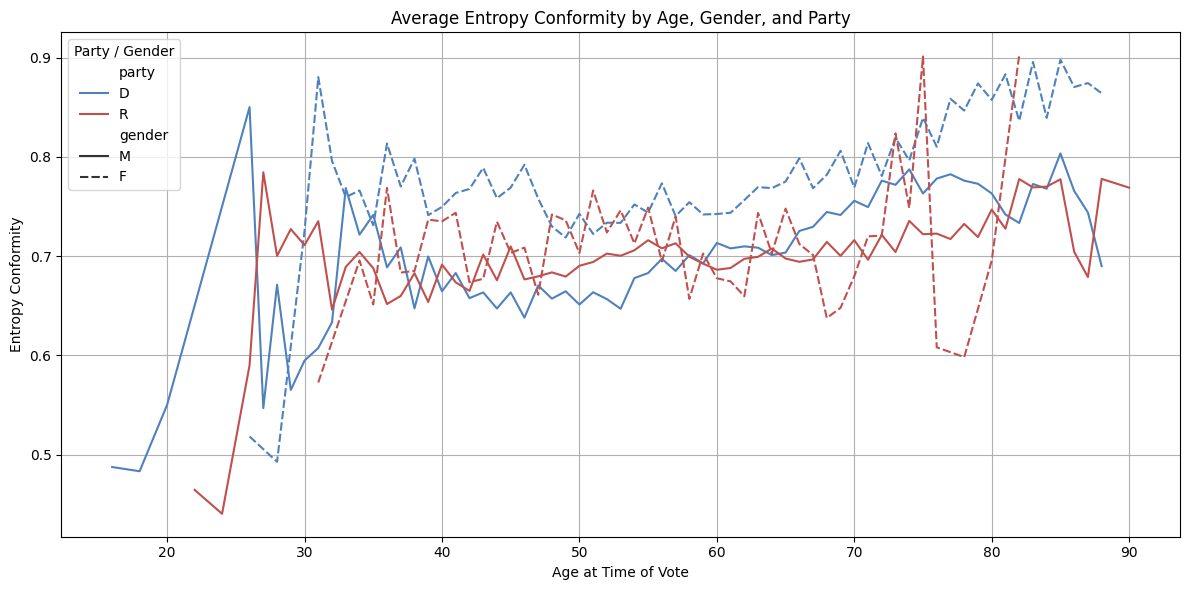

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and compute age
subset = df[
    df["gender"].isin(["M", "F"]) &
    df["party"].isin(["D", "R"]) &
    df["birth_year"].notna()
].copy()

subset["age"] = subset["year"] - subset["birth_year"]

# Group by age, gender, and party
grouped = (
    subset.groupby(["age", "gender", "party"])["avg_entropy_conformity"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped,
    x="age",
    y="avg_entropy_conformity",
    hue="party",
    style="gender",
    palette={"D": "#4F81BD", "R": "#C0504D"}
)

plt.title("Average Entropy Conformity by Age, Gender, and Party")
plt.xlabel("Age at Time of Vote")
plt.ylabel("Entropy Conformity")
plt.legend(title="Party / Gender")
plt.grid(True)
plt.tight_layout()


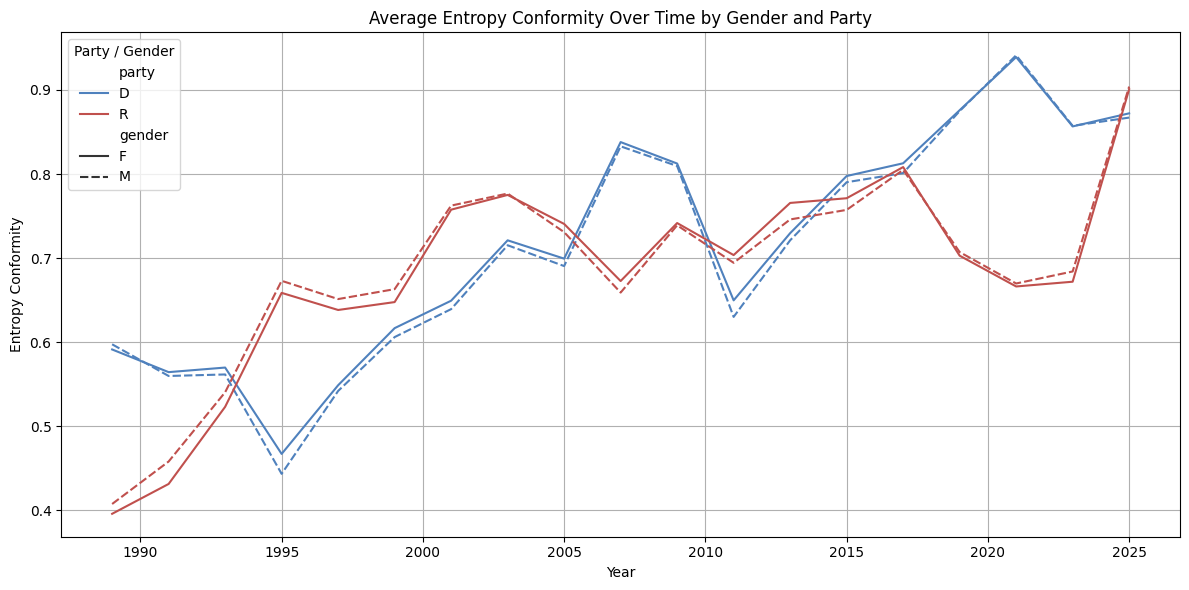

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for valid gender and party
subset = df[
    df["gender"].isin(["M", "F"]) &
    df["party"].isin(["D", "R"])
].copy()

# Group by year, gender, and party
grouped = (
    subset.groupby(["year", "gender", "party"])["avg_entropy_conformity"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped,
    x="year",
    y="avg_entropy_conformity",
    hue="party",
    style="gender",
    palette={"D": "#4F81BD", "R": "#C0504D"}
)

plt.title("Average Entropy Conformity Over Time by Gender and Party")
plt.xlabel("Year")
plt.ylabel("Entropy Conformity")
plt.legend(title="Party / Gender")
plt.grid(True)
plt.tight_layout()


<ipython-input-46-4b3c1ec5a80e>:18: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.




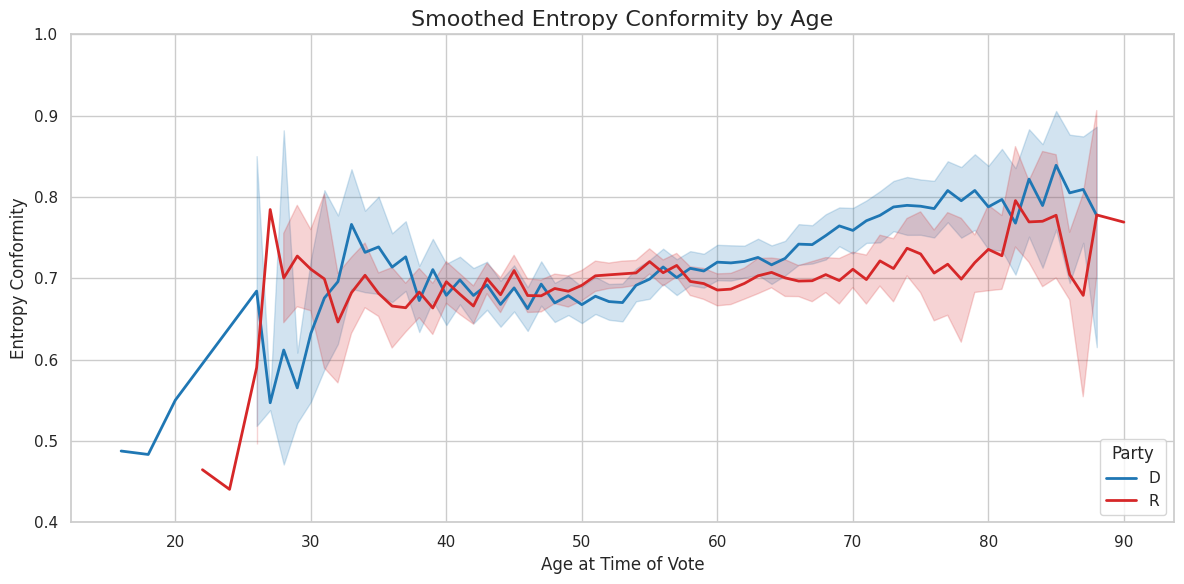

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
subset = df[
    df["party"].isin(["D", "R"]) &
    df["gender"].isin(["M", "F"]) &
    df["birth_year"].notna()
].copy()

subset["age"] = subset["year"] - subset["birth_year"]

# Plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.lineplot(
    data=subset,
    x="age",
    y="avg_entropy_conformity",
    hue="party",
    palette={"D": "#1f77b4", "R": "#d62728"},
    ci=95,
    estimator="mean",
    lw=2
)

plt.title("Smoothed Entropy Conformity by Age", fontsize=16)
plt.xlabel("Age at Time of Vote", fontsize=12)
plt.ylabel("Entropy Conformity", fontsize=12)
plt.ylim(0.4, 1.0)
plt.legend(title="Party", loc="lower right")
plt.tight_layout()


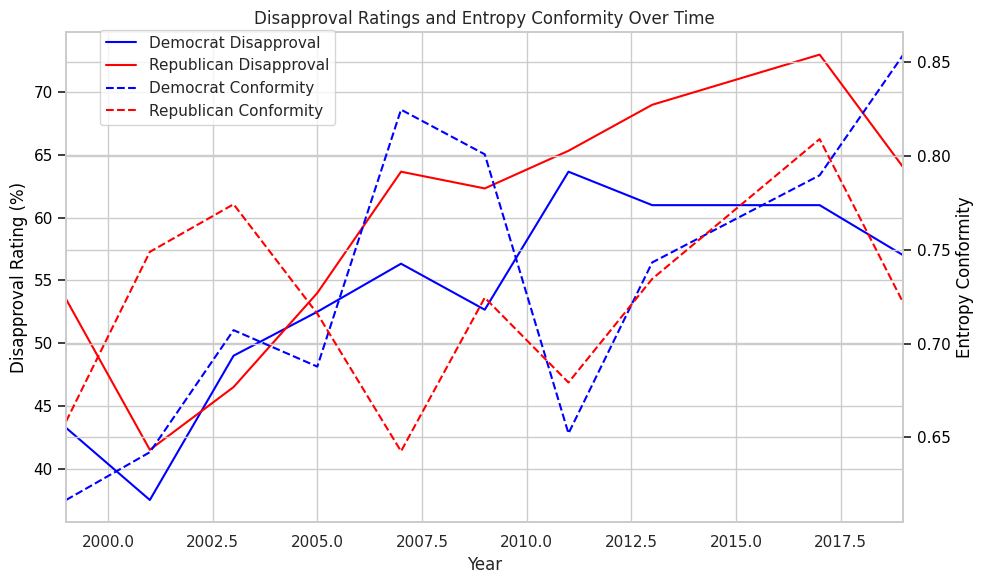

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and clean approval data ---
approval_repubs = pd.read_csv("data-DUWR7.csv", skiprows=1)
approval_dems = pd.read_csv("data-myxqm.csv", skiprows=1)

# Rename columns
approval_repubs.columns = ["date", "Approve", "Disapprove", "No opinion"]
approval_dems.columns = ["date", "Approve", "Disapprove", "No opinion"]

# Extract year
def extract_year(date_str):
    try:
        return int(date_str.split()[0])
    except:
        return None

approval_repubs["year"] = approval_repubs["date"].apply(extract_year)
approval_dems["year"] = approval_dems["date"].apply(extract_year)

# Convert to numeric
approval_repubs["Disapprove"] = pd.to_numeric(approval_repubs["Disapprove"], errors="coerce")
approval_dems["Disapprove"] = pd.to_numeric(approval_dems["Disapprove"], errors="coerce")

# Average disapproval by year
avg_repub = approval_repubs.groupby("year")["Disapprove"].mean().reset_index().rename(columns={"Disapprove": "Republican Disapproval"})
avg_dem = approval_dems.groupby("year")["Disapprove"].mean().reset_index().rename(columns={"Disapprove": "Democrat Disapproval"})

# Clean conformity data
avg_conform = df.groupby(["year", "party"])["avg_entropy_conformity"].mean().reset_index()
pivot_conform = avg_conform.pivot(index="year", columns="party", values="avg_entropy_conformity").reset_index()
pivot_conform.columns.name = None
pivot_conform = pivot_conform.rename(columns={"D": "Democrat Conformity", "R": "Republican Conformity"})

# Merge all data
merged = avg_dem.merge(avg_repub, on="year", how="inner").merge(pivot_conform, on="year", how="inner")
merged = merged.sort_values("year")

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# Left Y-axis: Disapproval Ratings
ax1.set_xlabel("Year")
ax1.set_ylabel("Disapproval Rating (%)", color="black")
ax1.plot(merged["year"], merged["Democrat Disapproval"], label="Democrat Disapproval", color="blue", linestyle='-')
ax1.plot(merged["year"], merged["Republican Disapproval"], label="Republican Disapproval", color="red", linestyle='-')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim(merged["year"].min(), merged["year"].max())

# Right Y-axis: Entropy Conformity
ax2 = ax1.twinx()
ax2.set_ylabel("Entropy Conformity", color="black")
ax2.plot(merged["year"], merged["Democrat Conformity"], label="Democrat Conformity", color="blue", linestyle='--')
ax2.plot(merged["year"], merged["Republican Conformity"], label="Republican Conformity", color="red", linestyle='--')
ax2.tick_params(axis='y', labelcolor='black')

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", bbox_to_anchor=(0.1, 0.95))

plt.title("Disapproval Ratings and Entropy Conformity Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Target: high entropy conformer
df["conformer"] = df["avg_entropy_conformity"] > 0.75
df["age"] = df["year"] - df["birth_year"]
df["tenure"] = df["year"] - df["first_year_served"]

# Define features
features = ["party", "chamber", "gender", "age", "tenure", "margin_of_control"]
target = "conformer"

# Drop missing
model_df = df[features + [target]].dropna().copy()
X = model_df[features]
y = model_df[target]

# Column types
categorical = ["party", "chamber", "gender"]
numeric = ["age", "tenure", "margin_of_control"]

# Preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical),
    ("num", StandardScaler(), numeric)
])

# Pipeline
clf_pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, random_state=0)
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
clf_pipeline.fit(X_train, y_train)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, clf_pipeline.predict(X_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf_pipeline.predict(X_test)))


Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.93      0.93      1372
        True       0.90      0.90      0.90       915

    accuracy                           0.92      2287
   macro avg       0.92      0.92      0.92      2287
weighted avg       0.92      0.92      0.92      2287

Confusion Matrix:
[[1280   92]
 [  93  822]]


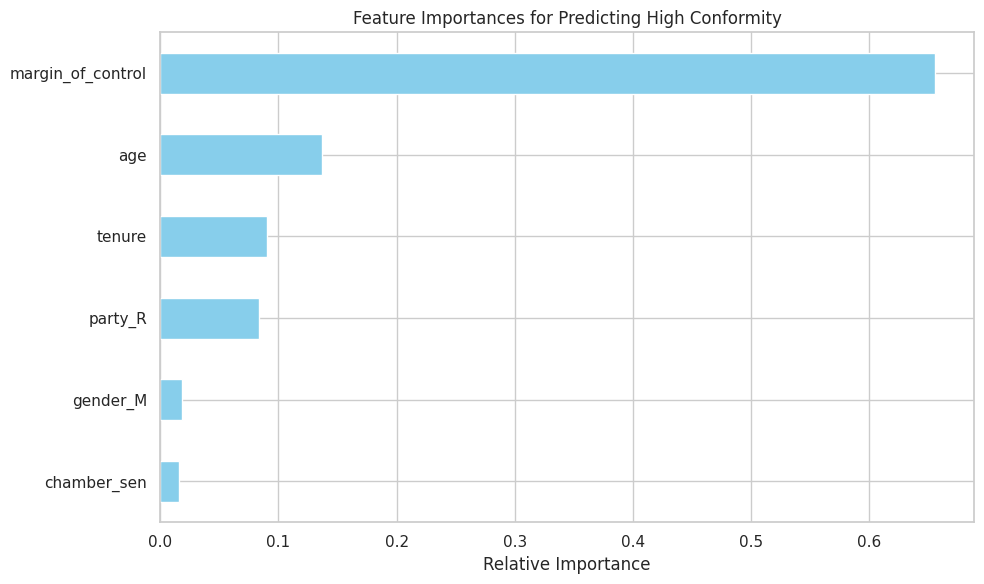

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names from preprocessor
ohe = clf_pipeline.named_steps["columntransformer"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical).tolist()
all_features = cat_features + numeric

# Get importances
importances = clf_pipeline.named_steps["randomforestclassifier"].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
feat_imp.plot(kind="barh", color="skyblue")
plt.title("Feature Importances for Predicting High Conformity")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Recalculate target and derived features
df["conformer"] = df["avg_entropy_conformity"] > 0.75
df["age"] = df["year"] - df["birth_year"]
df["tenure"] = df["year"] - df["first_year_served"]

# Define features
features = ["party", "chamber", "gender", "age", "tenure", "margin_of_control"]
target = "conformer"

# Drop missing
model_df = df[features + [target]].dropna().copy()
X = model_df[features]
y = model_df[target]

# Column types
categorical = ["party", "chamber", "gender"]
numeric = ["age", "tenure", "margin_of_control"]

# Preprocessing
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical),
    ("num", StandardScaler(), numeric)
])

# Logistic regression pipeline
clf_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
clf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['party', 'chamber',
                                                   'gender']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'tenure',
                                                   'margin_of_control'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

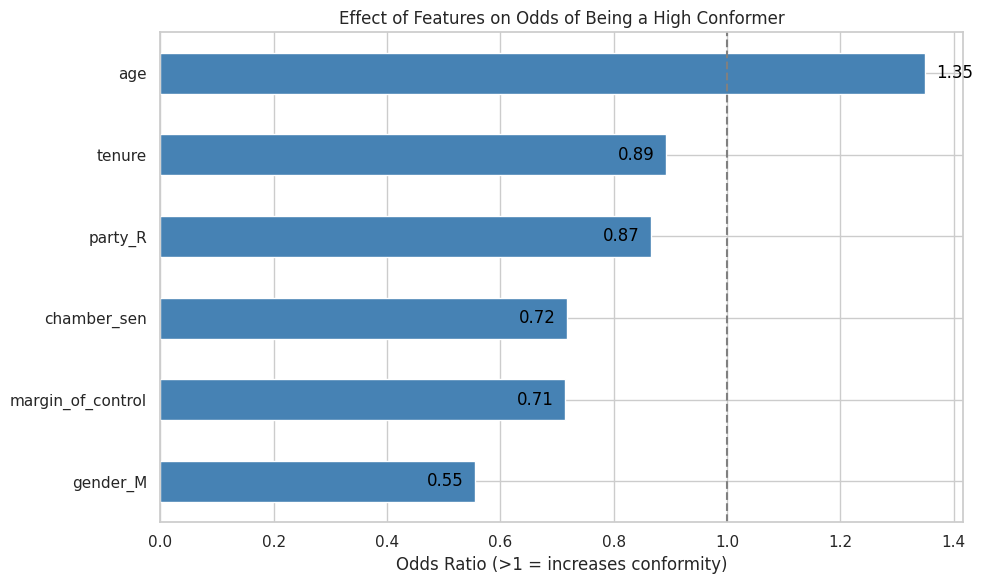

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Get odds ratios
odds_ratios = np.exp(coefs)
odds_df = pd.Series(odds_ratios, index=all_features).sort_values()

# Plot
plt.figure(figsize=(10, 6))
bars = odds_df.plot(kind="barh", color="steelblue")
plt.axvline(1, color="gray", linestyle="--")  # baseline odds

# Annotate
for i, v in enumerate(odds_df):
    plt.text(v + 0.02 if v >= 1 else v - 0.02, i, f"{v:.2f}",
             color="black", va="center", ha="left" if v >= 1 else "right")

plt.title("Effect of Features on Odds of Being a High Conformer")
plt.xlabel("Odds Ratio (>1 = increases conformity)")
plt.tight_layout()
plt.show()


In [80]:
df.to_csv("conform.csv", index=False)

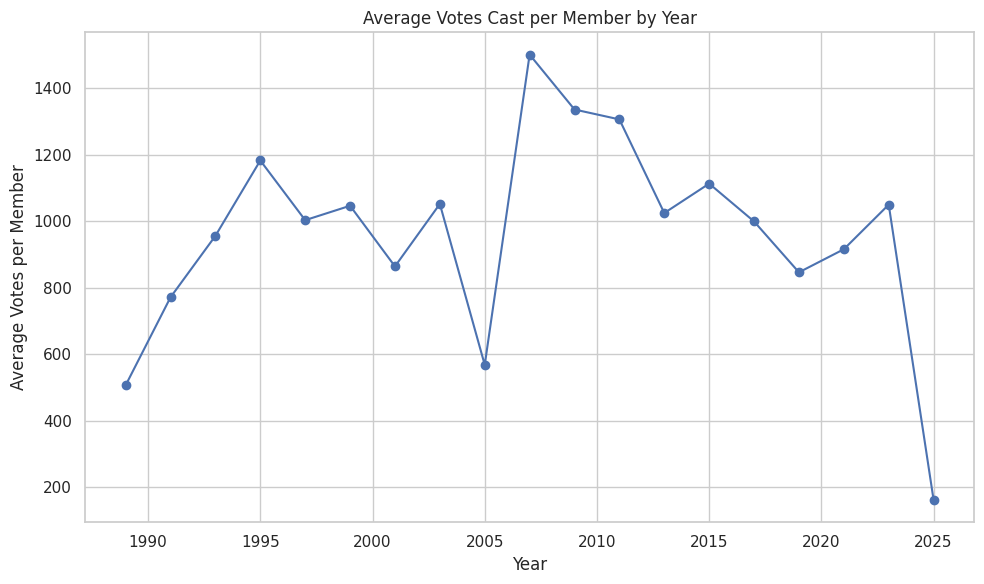

In [81]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate total votes cast per Congress
votes_by_congress = df.groupby("congress")["votes_cast"].sum()

# Calculate the number of unique members per Congress
members_by_congress = df.groupby("congress")["member_id"].nunique()

# Compute average votes per member for each Congress
avg_votes_per_member = votes_by_congress / members_by_congress

# Convert Congress number to starting year (each Congress lasts 2 years, starting from 1789)
years = avg_votes_per_member.index * 2 + 1787

# Plot the average votes per member over time
plt.figure(figsize=(10, 6))
plt.plot(years, avg_votes_per_member.values, marker='o', linestyle='-')
plt.title("Average Votes Cast per Member by Year")
plt.xlabel("Year")
plt.ylabel("Average Votes per Member")
plt.grid(True)
plt.tight_layout()
plt.show()


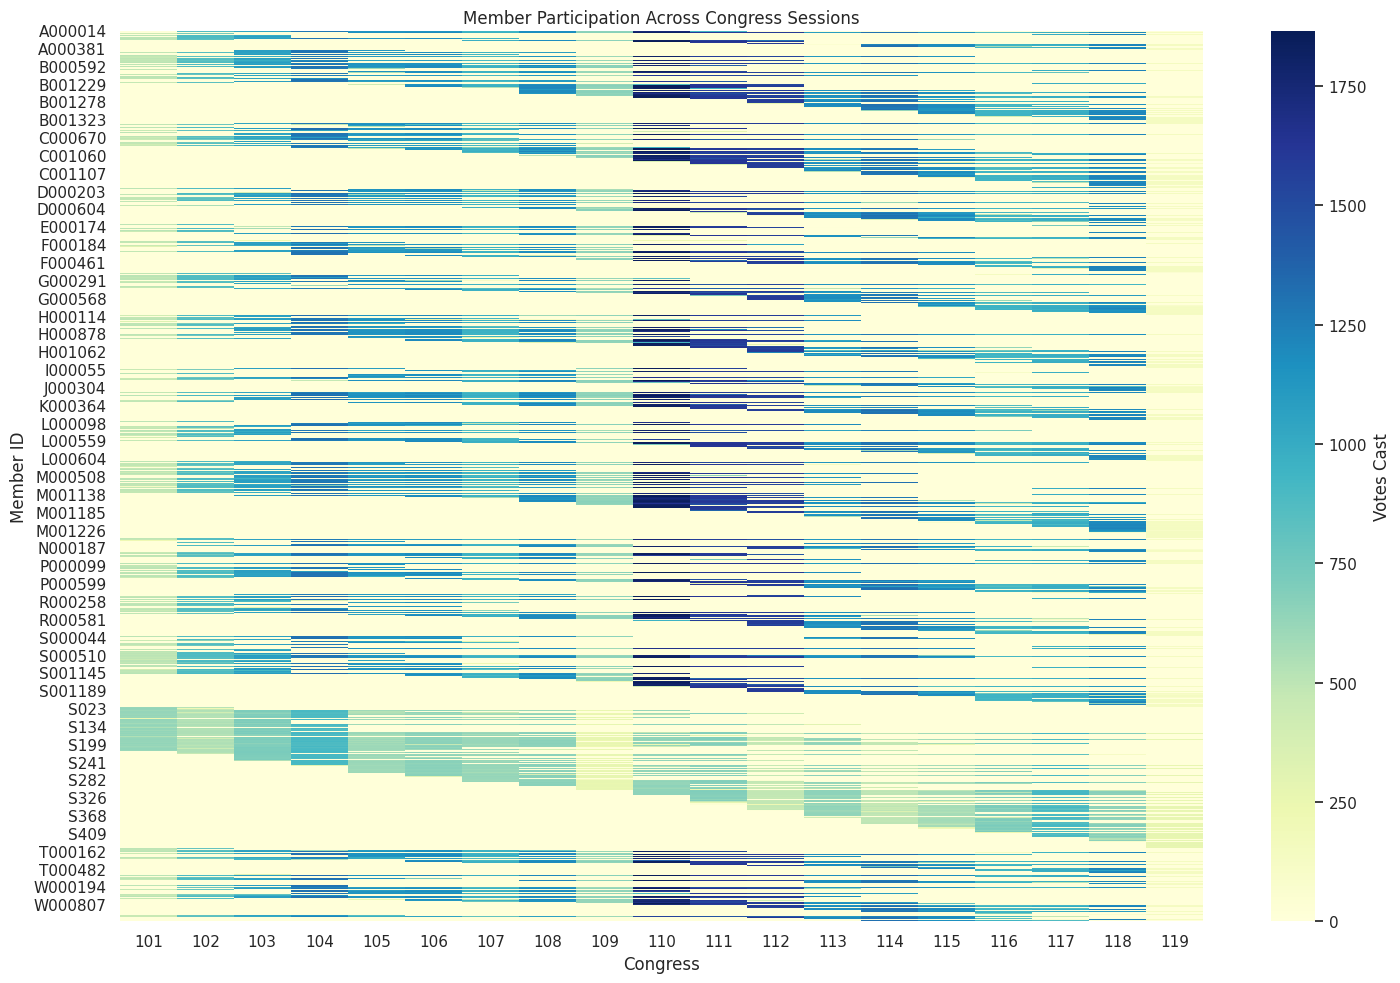

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table with members as rows and Congress sessions as columns
participation = df.pivot_table(index='member_id', columns='congress', values='votes_cast', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(participation, cmap='YlGnBu', cbar_kws={'label': 'Votes Cast'})
plt.title("Member Participation Across Congress Sessions")
plt.xlabel("Congress")
plt.ylabel("Member ID")
plt.tight_layout()
plt.show()


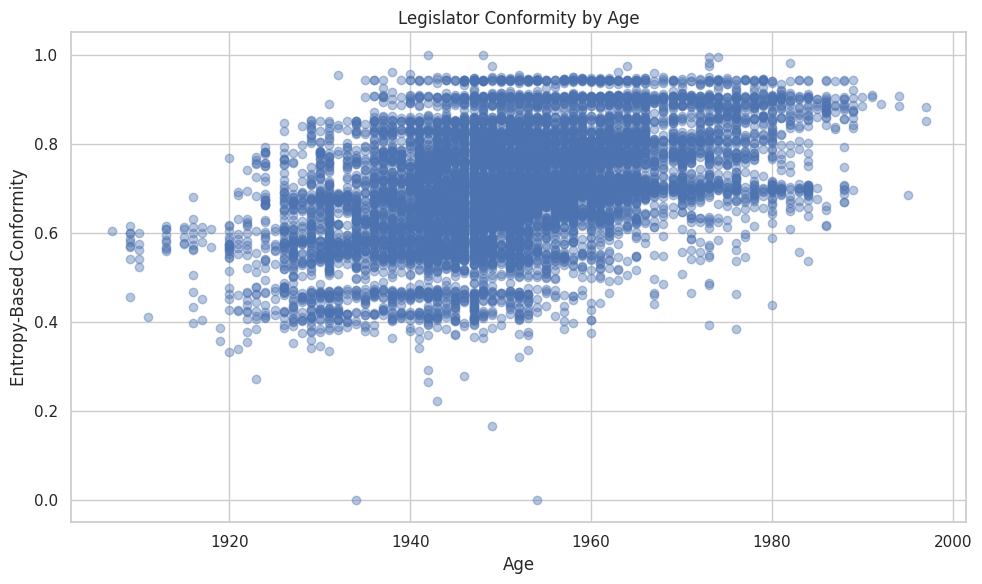

In [86]:
import matplotlib.pyplot as plt

# Filter out rows with missing age or conformity values
filtered_df = df.dropna(subset=["birth_year", "year", "avg_entropy_conformity"])

# Compute age

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["birth_year"], filtered_df["avg_entropy_conformity"], alpha=0.4)
plt.title("Legislator Conformity by Age")
plt.xlabel("Age")
plt.ylabel("Entropy-Based Conformity")
plt.grid(True)
plt.tight_layout()
plt.show()
